## Import Libraries

In [24]:
from coinbase.wallet.client import Client
import cbpro

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from abc import ABC, abstractmethod 
from enum import Enum

%matplotlib inline

## Connect to API for my Account

In [2]:
import config
client = Client(config.apiKey, config.apiSecret, api_version = config.apiVersion)

btcCurrencyPair = 'ETH-USD'

price = client.get_spot_price(currency_pair = btcCurrencyPair)
price

<APIObject @ 0x189d4d38cc0> {
  "amount": "1531.51",
  "base": "ETH",
  "currency": "USD"
}

## Useful Functions

In [3]:
def UnixToDate(time): 
    return datetime.fromtimestamp(time)

In [4]:
def isGranularityOption(g):
    #1 min, 5 min, 15 min, 1 hr, 6 hrs, 1 day
    possibleGranularities = [60, 300, 900, 3600, 21600, 86400] 
    return (g in possibleGranularities)

In [5]:
from datetime import datetime
def unixToISO8601(unixTime):
    t =  int(unixTime)
    return str(datetime.fromtimestamp(t).isoformat())

In [25]:
def x_YearsAgoInUnixTime(years):
    today = int(time.time())
    secodnsPerYear = 31536000
    return (today - (years*secodnsPerYear))
def x_MonthsAgoInUnixTime(months):
    today = int(time.time())
    secodnsPerMonth = 2628000 #average sec/month
    return (today - (months*secodnsPerMonth))
def x_DaysAgoInUnixTime(days):
    today = int(time.time())
    secodnsPerDay = 86400
    return (today - (days*secodnsPerDay))

class Granularities(Enum):
    Minute = 60
    FiveMinutes = 300
    FifteenMinutes = 900
    Hour = 3600
    SixHours = 21600
    Day = 86400
    

In [7]:
#API will only return 300 bins at once so if you input a big range you will need to call API multiple times
def calcNumberofCallsNeeded(startTime_unix, endTime_unix, granularity):
    maxBins = 300
    maxTime = maxBins * granularity
    if maxTime < endTime_unix - startTime_unix:
        return ((endTime_unix - startTime_unix)//maxTime) + 1 #add 1 cause we want ceiling(x)
    else:
        return 1

In [8]:
#takes ticker and granularity and a start and end time and returns a dataFrame of the data
import time
def getData(tickerPair, granularity, startTime_unix, endTime_unix = int(time.time())):
    if isGranularityOption(granularity) and endTime_unix > startTime_unix:  
        numCalls = calcNumberofCallsNeeded(startTime_unix,endTime_unix, granularity)

        data = []
        isoStart = unixToISO8601(startTime_unix)
        isoEnd = unixToISO8601(endTime_unix)
        if numCalls == 1:
            data = public_client.get_product_historic_rates(tickerPair, isoStart, isoEnd, granularity)
        else:
            for i in range(numCalls + 1):
                currentStep = 300*i*granularity #300 is max bins coinbase API will return at once
                isoStart = unixToISO8601(endTime_unix-currentStep)
                temp = public_client.get_product_historic_rates(tickerPair, isoStart, isoEnd, granularity)
                isoEnd = isoStart
                for element in temp: #data is 2D so loop to append, make prettier later
                    data.append(element)
           
        df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close','volume'])
        df.set_index('date', inplace=True)
        return df.iloc[::-1] #reverse order so its chronological
    else:
        print("Input error, use one of the following granularity values [60, 300, 900, 3600, 21600, 86400]\
        and make sure the start time is before the end time")
        return None

In [9]:
import plotly.graph_objects as go
def plotCandles(df):
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close'])])
    fig.show()

In [10]:
def plotLine(df,ticker):
    fig = plt.figure(1,figsize=(8, 5))
    plt.plot(df['close'],label = ticker)
    plt.xlabel("Unix Time")
    plt.ylabel("Price-USD")
    start = UnixToDate(df.index[-1])
    end = UnixToDate(df.index[0])
    plt.title("{}-USD from {} to {}".format(ticker,start,end))
    plt.legend()
    return fig

## Trade Indicator Functions

#### 1) RSI - Can be calculate with SMA or EMA

In [21]:
class AbstractTradingStrategy(ABC):
    @abstractmethod
    def calcIndicator(self,df,granularity):
        pass
    @abstractmethod
    def buySignal(self):
        pass
    @abstractmethod
    def sellSignal(self):
        pass
    
class RSI(AbstractTradingStrategy):
    
    def __init__(self,lookbackPeriod = 14, funcType = "SMA", buyThreshold = 30, sellThreshold = 70):
            self.lookbackPeriod = lookbackPeriod
            self.buyThreshold = buyThreshold
            self.sellThreshold = sellThreshold
            self.funcType = funcType
            
    def calcIndicator(self, df, granularity = 86400):
        data = df.drop('volume',axis = 1)
        data["RSI"] = np.nan
        data['change'] = data['close'].diff(1)
        if self.funcType == "SMA":
            data['RSI'] = data['change'].rolling(window=self.lookbackPeriod).apply(RSI.SMA_Helper)
        elif self.funcType == "EMA":
            posChanges = data['change'].mask(data['change'] < 0, other = 0) #use mask to maintain length
            negChanges =  data['change'].mask(data['change'] > 0, other = 0) 
            upEWM = posChanges.ewm(com=self.lookbackPeriod-1,min_periods = self.lookbackPeriod).mean()
            downEWM = negChanges.ewm(com=self.lookbackPeriod-1,min_periods = self.lookbackPeriod).mean()
            relativeStrength = abs(upEWM/downEWM)
            data['RSI'] = (100 - (100/(1 + relativeStrength)))
        else:
            print("Not a valid RSI function type")
            return None

        return data['RSI'] #subject to change not sure how I'm going to use, maybe just edit initial df and dont delete volume
    
    def buySignal(self,val):
        return val <= self.buyThreshold 
    def sellSignal(self):
        return val >= self.sellThreshold         
    
    def SMA_Helper(period): #period is last n changes in closing price
        avgOfPositives = np.mean(period[period > 0])
        avgOfNegatives = np.mean(period[period < 0])
        relativeStrength =  abs(avgOfPositives/avgOfNegatives)
        return (100 - (100/(1 + relativeStrength)))




## Back Testing

In [26]:
strategies = [RSI(),RSI(funcType = "EMA")]
#the way its implemented now I cannot optimize the buy/sell thresholds
#could put some in list manually but thats against point

dateRange = [x_DaysAgoInUnixTime(100),x_DaysAgoInUnixTime(0)]
tickerPair = "BTC-USD"
granularity = Granularities.Day
savePeriods = 30 #how much data should be kept at a time (30 granularities worth)
balance = 1000 
buyAmmount = balance/5 

currentData = pd.DataFrame() #all data going back 'n' savePeriods
for time in np.arange(dateRange[0],dateRange[1],granularity):
    currentData = currentData.append(getData(tickerPair, granularity, time, time+granularity))
    botsTime = time + granularity #anything before this time has "already happened" anyhting after is "future"


## Example -- BTC Data

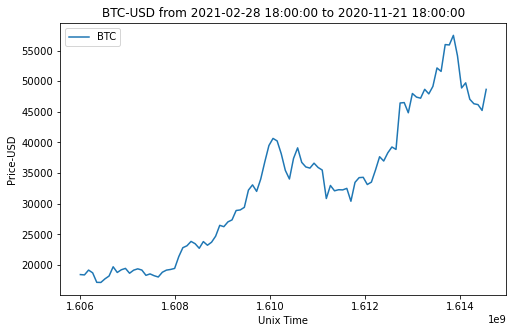

In [13]:
public_client = cbpro.PublicClient()

#careful, can overflow memory and break if you get too much data
granularity = 86400
btc = getData("BTC-USD", granularity, x_DaysAgoInUnixTime(100)) 
fig = plotLine(btc,"BTC")


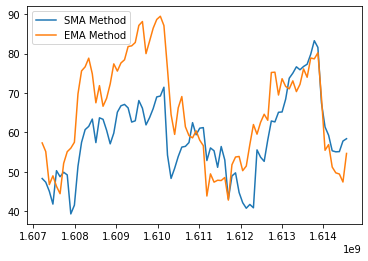

In [22]:
# plt.figure(2,figsize=(8, 5))
# SMA = relativeStrengthIndex(btc)
# EMA = relativeStrengthIndex(btc, funcType = "EMA")
# plt.plot(SMA,label="SMA Method")
# plt.plot(EMA,label="EMA Method")
# plt.legend()
#base = AbstractTradingStrategy()
relativeStrengthSMA = RSI()
relativeStrengthEMA = RSI(funcType = "EMA")
SMA = relativeStrengthSMA.calcIndicator(btc,86400)
EMA = relativeStrengthEMA.calcIndicator(btc,86400)
plt.plot(SMA,label="SMA Method")
plt.plot(EMA,label="EMA Method")
plt.legend()